### Example of Applying Augmentation with Downsampling

Model G6.2, ISIC 2018 dataset, Barata et al. (2021) - ResNet-50 model variant, focal loss function, batch size = 32, lr = 1e-5, augmentation = Yes, Top 32 layers trainable

In [ ]:
#import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet import preprocess_input
import tensorflow as tf
import random

#for support with focal loss
import tensorflow.keras.backend as K

In [ ]:
#Flags (class with general configurations)
class Flags:
    dim_hidden = 512
    ratio = 8
    learning_rate = 1e-5
    num_classes = 7
    batch_size = 32
    max_epochs = 40 #later dataset testing
    patience = 5
    input_shape = (224, 224, 3)

In [ ]:
#enable focal loss
def categorical_focal_loss(alpha=1.0, gamma=1.5):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss_fn

In [ ]:
#setup for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#general configuration
LOSS ='categorical_crossentropy'
NUM_CLASSES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
LOSS = categorical_focal_loss(alpha=1.0, gamma=1.5)  #Balanced via augmentation - alpha=None or 1.0, gamma=1.0-2.0, mild imbalance - 0.75 for alpha and 1.5 for gamma, imbalanced - alpha=0.25, gamma=2.0

In [ ]:
#Attention module
def channel_attention(inputs, ratio=8):
    channel = inputs.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    shared_dense = tf.keras.Sequential([
        layers.Conv2D(channel // ratio, 1, activation='relu', padding='same'),
        layers.Conv2D(channel, 1, padding='same')
    ])

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    scale = layers.Activation('sigmoid')(layers.Add()([avg_out, max_out]))
    return layers.Multiply()([inputs, scale])

#Hierachical Attention based module, #build the model, fine-tuning and allowing training from layer 140
def build_resnet50_attention_lstm_model(input_shape=(224, 224, 3), num_classes=Flags.num_classes, learning_rate = Flags.learning_rate):
    input_layer = layers.Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)

    for layer in base_model.layers[:140]:
        layer.trainable = False
    for layer in base_model.layers[140:]:
        layer.trainable = True

    x = base_model.output
    x = channel_attention(x, ratio=Flags.ratio)
    x = layers.Reshape((-1, 2048))(x)

    avg_feat = layers.GlobalAveragePooling1D()(x)
    init_state = layers.Dense(Flags.dim_hidden * 2, activation='tanh')(avg_feat)
    h_state = layers.Lambda(lambda z: z[:, :Flags.dim_hidden])(init_state)
    c_state = layers.Lambda(lambda z: z[:, Flags.dim_hidden:])(init_state)

    lstm_out, _, _ = layers.LSTM(Flags.dim_hidden, return_sequences=True, return_state=True)(x, initial_state=[h_state, c_state])
    x_proj = layers.Dense(Flags.dim_hidden)(x)
    context = layers.Attention()([lstm_out, x_proj])
    context = layers.GlobalAveragePooling1D()(context)

    x = layers.Concatenate()([context, avg_feat])
    x = layers.Dense(Flags.dim_hidden, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(Flags.num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss=LOSS,metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
#............ Utility Functions ............

#extracts downloaded data from zip file format
def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

#loads and preprocesses the label data (target)
def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)
    df['new_image_id'] = df['image'] + ".jpg"

    #create label column from diagnosis columns
    diagnosis_cols = NUM_CLASSES

    #find the index (i.e., label) where the value is 1
    df['label'] = df[diagnosis_cols].idxmax(axis=1)

    #map string labels to integers
    label_mapping = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
    df['label'] = df['label'].map(label_mapping)

    return df

#determine the distribution of classes in the dataset
def show_class_distribution(y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)

    class_labels = [
        'Melanoma (0)',         # MEL
        'Nevus (1)',            # NV
        'Basal Cell Carcinoma (2)',  # BCC
        'Actinic Keratosis (3)',     # AKIEC
        'Benign Keratosis (4)',      # BKL
        'Dermatofibroma (5)',        # DF
        'Vascular Lesion (6)'        # VASC
    ]

    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        class_name = class_labels[label] if label < len(class_labels) else f"Unknown Class ({label})"
        print(f"  Class {label} ({class_name}): {count} samples")

#apply fixed augmentations to underrepresented classes
def augment_image_fixed(img, mode):
    if mode == 'flip_lr':
        img = tf.image.flip_left_right(img)
    elif mode == 'flip_ud':
        img = tf.image.flip_up_down(img)
    elif mode == 'rot90':
        img = tf.image.rot90(img, k=1)
    elif mode == 'rot180':
        img = tf.image.rot90(img, k=2)
    return img

#load and augment_images()
def load_and_augment_images(df, img_dir, seed=42):
    X_aug = []
    y_aug = []

    augment_modes = ['flip_lr', 'flip_ud', 'rot90', 'rot180']
    rng = np.random.default_rng(seed)

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['new_image_id'])
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, Flags.input_shape[:2])
        img = img.astype('float32') / 255.0

        X_aug.append(img)
        y_aug.append(row['label'])

        if row['label'] in [2, 3, 5, 6]:
            tf_img = tf.convert_to_tensor(img)
            for mode in augment_modes:
                aug_img = augment_image_fixed(tf_img, mode)
                X_aug.append(aug_img.numpy())
                y_aug.append(row['label'])

    #shuffle using consistent seed
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    idx = rng.permutation(len(X_aug))  # uses np.random.Generator for reproducibility
    return X_aug[idx], y_aug[idx]

#downsamples majority classes in a DataFrame to match the target_count
def downsample_selected_classes(df, target_count=1113, labels_to_downsample=[1, 2, 3], label_col='label', random_state=42):
    downsampled_dfs = []

    for label in df[label_col].unique():
        class_subset = df[df[label_col] == label]

        if label in labels_to_downsample and len(class_subset) > target_count:
            class_subset = class_subset.sample(n=target_count, random_state=random_state)

        downsampled_dfs.append(class_subset)

    return pd.concat(downsampled_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

#show some augmented data samples
def show_augmented_samples(X, y, n=6):
    plt.figure(figsize=(12, 5))
    for i in range(n):
        plt.subplot(2, n // 2, i + 1)
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis("off")
    plt.suptitle('Sample data')
    plt.show()
#load the image dataset and preprocess e.g. correct color format, reszie, map labels
def load_images(df, img_dir):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['new_image_id'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is None:
                continue  # skip corrupted image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, Flags.input_shape[:2])
            X.append(img.astype('float32') / 255.0)
            y.append(row['label'])
    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {len(X)} images from {img_dir}")
    return X, y

#training of the model
def train_model(model, X, y, X_val, y_val):
    y_encoded = to_categorical(y, num_classes=Flags.num_classes)
    y_val_encoded = to_categorical(y_val, num_classes=Flags.num_classes)

    early_stop = EarlyStopping(
        #monitor='val_accuracy',
        monitor='val_auc',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

    class PrintLearningRate(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')
        val_auc = logs.get('val_auc')  # Optional, if using AUC
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  Learning Rate : {lr:.6f}")
        print(f"  Val Accuracy  : {val_acc:.4f}")
        print(f"  Val Loss      : {val_loss:.4f}")
        if val_auc is not None:
            print(f"  Val AUC       : {val_auc:.4f}")


    history = model.fit(
        X, y_encoded,
        validation_data=(X_val, y_val_encoded),
        epochs=Flags.max_epochs,
        batch_size=Flags.batch_size,
        #validation_split=0.2,
        callbacks=[early_stop, lr_scheduler, PrintLearningRate()],
        shuffle=True
    )
    return history


#evaluate the model based pn metrics e.g. accuracy, precision, recall, sensitivity, specificity
def evaluate_model(y_true, y_pred, y_proba, class_names):
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nSensitivity and Specificity per class:")
    for i, cls in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        print(f"Class: {cls}")
        print(f"  Sensitivity: {TP / (TP + FN):.4f}")
        print(f"  Specificity: {TN / (TN + FP):.4f}")

    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    auc_macro = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    auc_micro = roc_auc_score(y_true_bin, y_proba, average='micro', multi_class='ovr')
    auc_weighted = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')

    print(f"\nAUC (macro): {auc_macro:.4f}")
    print(f"AUC (micro): {auc_micro:.4f}")
    print(f"AUC (weighted): {auc_weighted:.4f}")

#show training history plot
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(True)
    plt.show()

#plot ROC curve for each class and micro/macro average ROC.
def plot_multiclass_roc(y_true, y_proba, class_names):
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    n_classes = y_true_bin.shape[1]

    #compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #plot all ROC curves
    plt.figure(figsize=(10, 8))

    #plot macro and micro averages
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC (area = {0:0.2f})'.format(roc_auc["micro"]),
             linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC (area = {0:0.2f})'.format(roc_auc["macro"]),
             linestyle=':', linewidth=4)

    #plot ROC curve for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC for class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
#mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

#paths -> Note replace these paths with the paths on appropriate drive e.g. Google drive
train_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_Input.zip"
test_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_Input.zip"
val_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_Input.zip"
train_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_GroundTruth.csv"
test_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_GroundTruth.csv"
val_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_GroundTruth.csv"
train_dir = "/content/ISIC2018_Task3_Training_Input"
test_dir = "/content/ISIC2018_Task3_Test_Input"
val_dir = "/content/ISIC2018_Task3_Validation_Input"


Mounted at /content/drive



Training Data - No Augmentation:
  Class 0 (Melanoma (0)): 1113 samples
  Class 1 (Nevus (1)): 6705 samples
  Class 2 (Basal Cell Carcinoma (2)): 514 samples
  Class 3 (Actinic Keratosis (3)): 327 samples
  Class 4 (Benign Keratosis (4)): 1099 samples
  Class 5 (Dermatofibroma (5)): 115 samples
  Class 6 (Vascular Lesion (6)): 142 samples

Testing Data - No Augmentation:
  Class 0 (Melanoma (0)): 171 samples
  Class 1 (Nevus (1)): 909 samples
  Class 2 (Basal Cell Carcinoma (2)): 93 samples
  Class 3 (Actinic Keratosis (3)): 43 samples
  Class 4 (Benign Keratosis (4)): 217 samples
  Class 5 (Dermatofibroma (5)): 44 samples
  Class 6 (Vascular Lesion (6)): 35 samples

Validation Data - No Augmentation:
  Class 0 (Melanoma (0)): 21 samples
  Class 1 (Nevus (1)): 123 samples
  Class 2 (Basal Cell Carcinoma (2)): 15 samples
  Class 3 (Actinic Keratosis (3)): 8 samples
  Class 4 (Benign Keratosis (4)): 22 samples
  Class 5 (Dermatofibroma (5)): 1 samples
  Class 6 (Vascular Lesion (6)): 3 

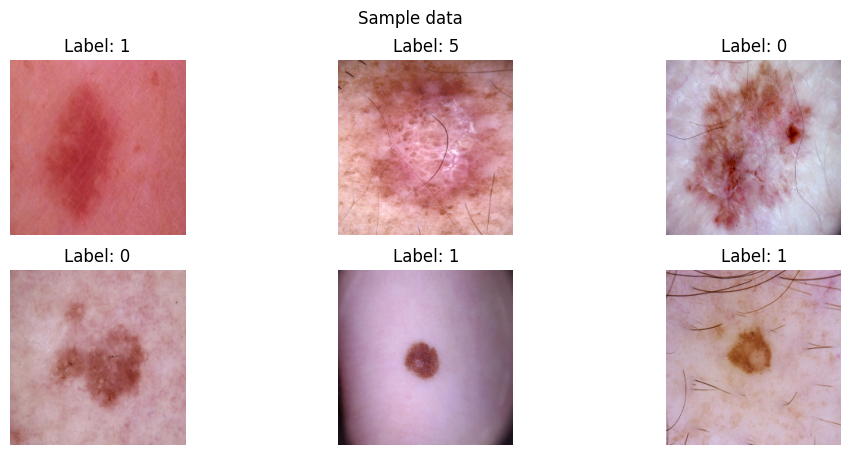


Not Augmented - Testing Data:
  Class 0 (Melanoma (0)): 171 samples
  Class 1 (Nevus (1)): 909 samples
  Class 2 (Basal Cell Carcinoma (2)): 93 samples
  Class 3 (Actinic Keratosis (3)): 43 samples
  Class 4 (Benign Keratosis (4)): 217 samples
  Class 5 (Dermatofibroma (5)): 44 samples
  Class 6 (Vascular Lesion (6)): 35 samples

Not Augmented - Validation Data:
  Class 0 (Melanoma (0)): 21 samples
  Class 1 (Nevus (1)): 123 samples
  Class 2 (Basal Cell Carcinoma (2)): 15 samples
  Class 3 (Actinic Keratosis (3)): 8 samples
  Class 4 (Benign Keratosis (4)): 22 samples
  Class 5 (Dermatofibroma (5)): 1 samples
  Class 6 (Vascular Lesion (6)): 3 samples


In [ ]:
#extract and Load
extract_zip(train_zip)
extract_zip(test_zip)
extract_zip(val_zip)
train_df = load_and_process_labels(train_csv)
test_df  = load_and_process_labels(test_csv)
val_df  = load_and_process_labels(val_csv)

#class distribution
show_class_distribution(train_df['label'].values, title="Training Data - No Augmentation")
show_class_distribution(test_df['label'].values, title="Testing Data - No Augmentation")
show_class_distribution(val_df['label'].values, title="Validation Data - No Augmentation")

#load Data
X_train, y_train = load_and_augment_images(train_df, train_dir,seed=SEED)
X_test, y_test = load_images(test_df, test_dir)
X_val, y_val = load_images(val_df, val_dir)

print("\nSanity Check:")
print(f"Final X_test shape: {X_test.shape}, dtype: {X_test.dtype}")
assert len(X_test.shape) == 4 and X_test.shape[1:] == (224, 224, 3), "X_test shape is invalid"

print("X_train shape:", X_train.shape)  # should be (N, 224, 224, 3)
assert len(X_train.shape) == 4 and X_train.shape[1:] == (224, 224, 3), "X_train shape is invalid"
print("y_train shape:", y_train.shape)  # should be (N,)


print("X_val shape:", X_val.shape)  # should be (N, 224, 224, 3)
assert len(X_val.shape) == 4 and X_val.shape[1:] == (224, 224, 3), "X_val shape is invalid"
print("y_val shape:", y_val.shape)  # should be (N,)

#after augmentation class distribution
show_class_distribution(y_train, title="After Augmentation - Training Data")

#show sample images after augmentation
show_augmented_samples(X_train, y_train, n=6)

#after class distribution
show_class_distribution(y_test, title="Not Augmented - Testing Data")
show_class_distribution(y_val, title="Not Augmented - Validation Data")

In [ ]:
# ---------------------------------------------------------------
#Downsample Benign and Melanoma to match SK (1270 samples each)
#create a dataframe from X_train and y_train
df_augmented = pd.DataFrame({'idx': np.arange(len(y_train)), 'label': y_train})

#downsample (only labels 1,2,3),downsample all classes to ~1000 samples, based on the smallest common class (e.g., DF = 575, VASC = 710)
df_downsampled = downsample_selected_classes(df_augmented, target_count=1113, labels_to_downsample=[1, 2, 3], label_col='label', random_state=42)




After Downsampling - Training Data:
  Class 0 (Melanoma (0)): 1113 samples
  Class 1 (Nevus (1)): 1113 samples
  Class 2 (Basal Cell Carcinoma (2)): 1113 samples
  Class 3 (Actinic Keratosis (3)): 1113 samples
  Class 4 (Benign Keratosis (4)): 1099 samples
  Class 5 (Dermatofibroma (5)): 575 samples
  Class 6 (Vascular Lesion (6)): 710 samples


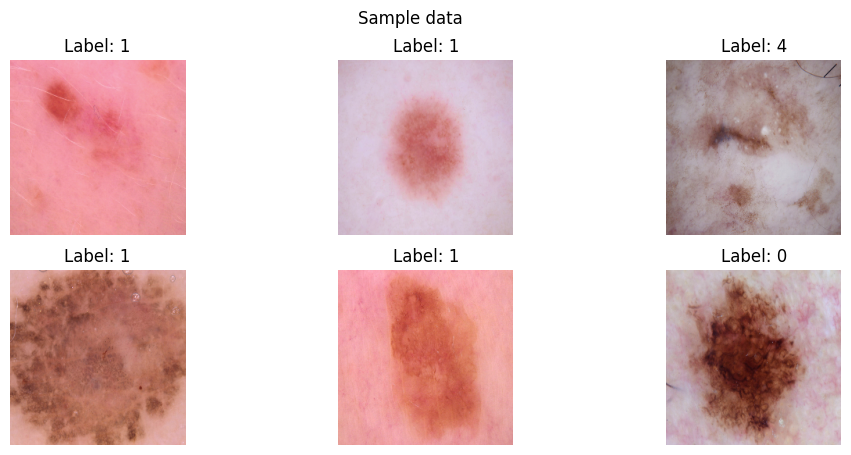

In [ ]:
#use the selected indices to get the filtered images and labels
X_train = X_train[df_downsampled['idx'].values]
y_train = y_train[df_downsampled['idx'].values]
# ---------------------------------------------------------------

#Confirm class balance
show_class_distribution(y_train, title="After Downsampling - Training Data")

#Show sample images
show_augmented_samples(X_test, y_test, n=6)

In [ ]:
#..................... Main Execution .....................

def main():

    #build and train model
    model = build_resnet50_attention_lstm_model((224, 224, 3), Flags.num_classes, Flags.learning_rate)

    #check which layers are trainable
    print("\nTrainable layers:")
    for layer in model.layers:
        if layer.trainable:
            print(f"  {layer.name}")

    model.summary()
    history = train_model(model, X_train, y_train, X_val, y_val)

    #predict and evaluate
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    evaluate_model(y_test, y_pred, y_proba, class_names=NUM_CLASSES)
    print(f"Balanced Accuracy (BACC): {balanced_accuracy_score(y_test, y_pred):.4f}")

    plot_multiclass_roc(y_test, y_proba, class_names=NUM_CLASSES)

    #plot training history
    plot_history(history)

    #save model and predictions
    model.save("/content/drive/MyDrive/Deep Learning/Results/skin_cancer_resnet50_model_v6.2.h5")
    pd.DataFrame({
        'Image': test_df['new_image_id'],
        'True Label': y_test,
        'Predicted Label': y_pred
    }).to_csv("/content/drive/MyDrive/Deep Learning/Results/prediction_results_v6.2.csv", index=False)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Trainable layers:
  conv4_block6_3_bn
  conv4_block6_add
  conv4_block6_out
  conv5_block1_1_conv
  conv5_block1_1_bn
  conv5_block1_1_relu
  conv5_block1_2_conv
  conv5_block1_2_bn
  conv5_block1_2_relu
  conv5_block1_0_conv
  conv5_block1_3_conv
  conv5_block1_0_bn
  conv5_block1_3_bn
  conv5_block1_add
  conv5_block1_out
  conv5_block2_1_conv
  conv5_block2_1_bn
  conv5_block2_1_relu
  conv5_block2_2_conv
  conv5_block2_2_bn
  conv5_block2_2_relu
  conv5_block2_3_conv
  conv5_block2_3_bn
  conv5_block2_add
  conv5_block2_out
  conv5_block3_1_conv
  conv5_block3_1_bn
  conv5_block3_1_relu
  conv5_block3_2_conv
  conv5_block3_2_bn
  conv5_block3_2_relu
  conv5_block3_3_conv
  conv5_block3_3_bn
  conv5_block3_add
  conv5_block3_out
  global_average_pooling2d
  global_max_pooling2d
  reshape
  reshape_1
  sequential
  add
  activation
  multiply
  reshape_2
  global_average_pooling1d
  dense
  lambda
  lambda_1
  lstm
  dense_1
  atten

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 34,345,607 (131.02 MB)

 Trainable params: 25,735,943 (98.17 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

Epoch 1/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2095 - auc: 0.5950 - loss: 1.5090
Epoch 1 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.1088
  Val Loss      : 1.6614
  Val AUC       : 0.3449
214/214 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.2097 - auc: 0.5953 - loss: 1.5086 - val_accuracy: 0.1088 - val_auc: 0.3449 - val_loss: 1.6614 - learning_rate: 1.0000e-05
Epoch 2/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3442 - auc: 0.7480 - loss: 1.2296
Epoch 2 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.3990
  Val Loss      : 1.3704
  Val AUC       : 0.6855
214/214 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.3442 - auc: 0.7481 - loss: 1.2294 - val_accuracy: 0.3990 - val_auc: 0.6855 - val_loss: 1.3704 - learning_rate: 1.0000e-05
Epoch 3/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4050 - auc: 0.7936 - loss: 1.1056
Epoch 3 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.3316
  Val Loss      : 1.6250
  

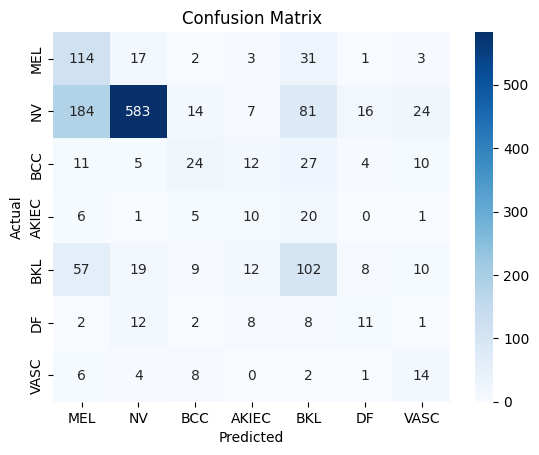


Sensitivity and Specificity per class:
Class: MEL
  Sensitivity: 0.6667
  Specificity: 0.8016
Class: NV
  Sensitivity: 0.6414
  Specificity: 0.9038
Class: BCC
  Sensitivity: 0.2581
  Specificity: 0.9718
Class: AKIEC
  Sensitivity: 0.2326
  Specificity: 0.9714
Class: BKL
  Sensitivity: 0.4700
  Specificity: 0.8695
Class: DF
  Sensitivity: 0.2500
  Specificity: 0.9796
Class: VASC
  Sensitivity: 0.4000
  Specificity: 0.9668

AUC (macro): 0.8456
AUC (micro): 0.8919
AUC (weighted): 0.8507
Balanced Accuracy (BACC): 0.4170


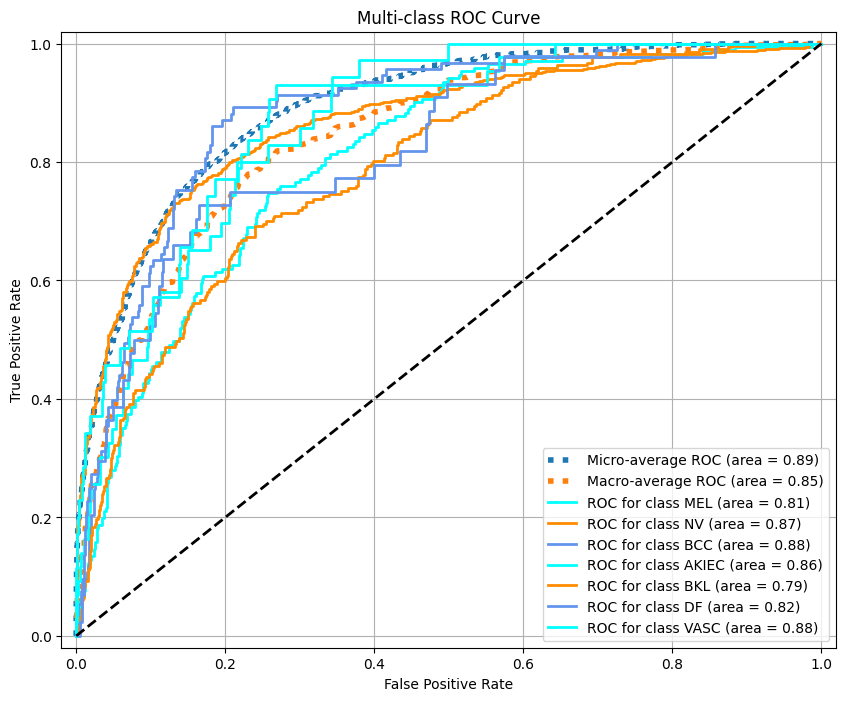

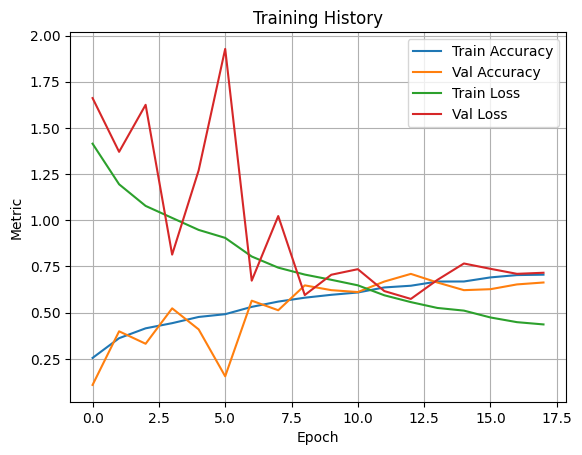

In [ ]:
#run the pipeline
main()